In [31]:
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import Linear,ReLU,Sigmoid,Tanh
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')
import os
os.listdir('./data')

['model_2.png', 'model_2.png.pdf', 'train(add_split_factor).csv', 'train.csv']

In [32]:
import numpy as np

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
def get_group_col(df,name):
    condition = df.columns.str.contains(name)
    return df.columns[condition].tolist()

In [34]:
df = pd.read_csv('./data/train(add_split_factor).csv',index_col=0)
print(df.shape)
df.head()

(14023, 436)


,Case Conditions_Feed Rate to C013 (Input),Case Conditions_C7+ in Light End (Input),Case Conditions_Heart Cut Prod. Rate (Input),Case Conditions_C6P- in Heart Cut (Input),Case Conditions_Feed Rate to C013 (Results),Case Conditions_C7+ in Light End (Results),Case Conditions_Heart Cut Prod. Rate (Results),Case Conditions_C6P- in Heart Cut (Results),Case Conditions_C10+ in Heart Cut (Results),Naphtha Properties_Naphtha Feed Rate,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane",Individual Component to Heavy End Split Factor_3-Methylnonane,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane,Individual Component to Heavy End Split Factor_n-Decane,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene",Individual Component to Heavy End Split Factor_n-Undecane,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Tridecane
0,10.0,2.5,100.0,1.0,10.000001,2.500057,100.000198,1.000427,6.138641,118.000084,...,0.348342,0.378793,0.381912,0.397334,0.409138,0.433925,0.440811,0.451332,0.454764,1.0
1,10.0,5.0,100.0,1.0,10.000001,4.999882,100.000122,1.000401,6.249050,118.000000,...,0.336983,0.367462,0.370631,0.386031,0.397878,0.422758,0.429677,0.440263,0.443717,1.0
2,10.0,10.0,100.0,1.0,10.000001,10.000006,100.000008,0.999993,6.376052,118.000000,...,0.323372,0.354403,0.357728,0.373260,0.385311,0.410579,0.417606,0.428374,0.431884,1.0
3,10.0,2.5,100.0,1.5,10.000001,2.500020,100.000275,1.500293,6.316332,118.000000,...,0.334064,0.360351,0.362654,0.376680,0.387033,0.409416,0.415640,0.425230,0.428354,1.0
4,10.0,5.0,100.0,1.5,10.000001,5.000001,99.999817,1.499961,6.416863,118.000084,...,0.323809,0.350009,0.352356,0.366307,0.376672,0.399048,0.405285,0.414893,0.418027,1.0


# defiine columns

In [35]:
case_col = df.columns[(df.columns.str.contains('Case'))&(df.columns.str.contains('Input'))].tolist()
case_col

['Case Conditions_Feed Rate to C013 (Input)',
 'Case Conditions_C7+ in Light End (Input)',
 'Case Conditions_Heart Cut Prod. Rate (Input)',
 'Case Conditions_C6P- in Heart Cut (Input)']

In [36]:
naphtha_col = df.columns[df.columns.str.contains('Naphtha Properties')].tolist()[5:-1]
print(len(naphtha_col))
naphtha_col[0],naphtha_col[-1]

54


('Naphtha Properties_Oxygen', 'Naphtha Properties_n-Tridecane')

In [37]:
s_col = get_group_col(df,'Individual Component')
print(len(s_col))

162


# sort s_col

In [38]:
df.columns

Index(['Case Conditions_Feed Rate to C013 (Input)',
       'Case Conditions_C7+ in Light End (Input)',
       'Case Conditions_Heart Cut Prod. Rate (Input)',
       'Case Conditions_C6P- in Heart Cut (Input)',
       'Case Conditions_Feed Rate to C013 (Results)',
       'Case Conditions_C7+ in Light End (Results)',
       'Case Conditions_Heart Cut Prod. Rate (Results)',
       'Case Conditions_C6P- in Heart Cut (Results)',
       'Case Conditions_C10+ in Heart Cut (Results)',
       'Naphtha Properties_Naphtha Feed Rate',
       ...
       'Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane',
       'Individual Component to Heavy End Split Factor_3-Methylnonane',
       'Individual Component to Heavy End Split Factor_tert-Butylcyclohexane',
       'Individual Component to Heavy End Split Factor_n-Decane',
       'Individual Component to Heavy End Split Factor_1,2-Diethylbenzene',
       'Individual Component to Heavy End Split Factor_n-Undecane',
       'Individu

In [39]:
temp = []
for i in [i.split('_')[1] for i in naphtha_col]:
    col1 = 'Individual Component to Light End Split Factor_{}'.format(i)
    col2 = 'Individual Component to Heart Cut Split Factor_{}'.format(i)
    col3 = 'Individual Component to Heavy End Split Factor_{}'.format(i)
    cols = [col1,col2,col3]
    temp += cols
s_col = temp
print(len(s_col))

162


In [40]:
for _ in range(1):
    idx = np.random.randint(0,163)
    fig = px.scatter_3d(df.sample(1000), 
                        x = case_col[1], 
                        y = case_col[2], 
                        z = case_col[3],
                        color = s_col[idx])
    fig.show()

# scale

In [41]:
x_col = case_col + naphtha_col
y_col = s_col

In [42]:
print(len(x_col))
print(len(y_col))

58
162


In [43]:
ss = StandardScaler().fit(df[x_col])
df[x_col] = ss.transform(df[x_col])

# split train test

In [44]:
X = df[x_col]
Y = df[y_col]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(12620, 58)
(1403, 58)
(12620, 162)
(1403, 162)


# tensor

In [45]:
X_train = torch.tensor(X_train.values, dtype=torch.float).cuda()
X_test = torch.tensor(X_test.values, dtype=torch.float).cuda()
Y_train = torch.tensor(Y_train.values, dtype=torch.float).cuda()
Y_test = torch.tensor(Y_test.values, dtype=torch.float).cuda()

# data_iter

In [46]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

# Construct the neural network

In [47]:
class Dual_net(nn.Module):
    def __init__(self):
        super(Dual_net,self).__init__()
        self.C_net = self._build_C_net(4,1)
        self.N_net = self._build_N_net(54,54) 
        self.F_net = self._build_F_net(55,55)
        # build O_net
        self.O_net1 = self._build_O_net(55,3)
        self.O_net2 = self._build_O_net(55,3)
        self.O_net3 = self._build_O_net(55,3)
        self.O_net4 = self._build_O_net(55,3)
        self.O_net5 = self._build_O_net(55,3)
        self.O_net6 = self._build_O_net(55,3)
        self.O_net7 = self._build_O_net(55,3)
        self.O_net8 = self._build_O_net(55,3)
        self.O_net9 = self._build_O_net(55,3)
        self.O_net10 = self._build_O_net(55,3)
        self.O_net11 = self._build_O_net(55,3)
        self.O_net12 = self._build_O_net(55,3)
        self.O_net13 = self._build_O_net(55,3)
        self.O_net14 = self._build_O_net(55,3)
        self.O_net15 = self._build_O_net(55,3)
        self.O_net16 = self._build_O_net(55,3)
        self.O_net17 = self._build_O_net(55,3)
        self.O_net18 = self._build_O_net(55,3)
        self.O_net19 = self._build_O_net(55,3)
        self.O_net20 = self._build_O_net(55,3)
        self.O_net21 = self._build_O_net(55,3)
        self.O_net22 = self._build_O_net(55,3)
        self.O_net23 = self._build_O_net(55,3)
        self.O_net24 = self._build_O_net(55,3)
        self.O_net25 = self._build_O_net(55,3)
        self.O_net26 = self._build_O_net(55,3)
        self.O_net27 = self._build_O_net(55,3)
        self.O_net28 = self._build_O_net(55,3)
        self.O_net29 = self._build_O_net(55,3)
        self.O_net30 = self._build_O_net(55,3)
        self.O_net31 = self._build_O_net(55,3)
        self.O_net32 = self._build_O_net(55,3)
        self.O_net33 = self._build_O_net(55,3)
        self.O_net34 = self._build_O_net(55,3)
        self.O_net35 = self._build_O_net(55,3)
        self.O_net36 = self._build_O_net(55,3)
        self.O_net37 = self._build_O_net(55,3)
        self.O_net38 = self._build_O_net(55,3)
        self.O_net39 = self._build_O_net(55,3)
        self.O_net40 = self._build_O_net(55,3)
        self.O_net41 = self._build_O_net(55,3)
        self.O_net42 = self._build_O_net(55,3)
        self.O_net43 = self._build_O_net(55,3)
        self.O_net44 = self._build_O_net(55,3)
        self.O_net45 = self._build_O_net(55,3)
        self.O_net46 = self._build_O_net(55,3)
        self.O_net47 = self._build_O_net(55,3)
        self.O_net48 = self._build_O_net(55,3)
        self.O_net49 = self._build_O_net(55,3)
        self.O_net50 = self._build_O_net(55,3)
        self.O_net51 = self._build_O_net(55,3)
        self.O_net52 = self._build_O_net(55,3)
        self.O_net53 = self._build_O_net(55,3)
        self.O_net54 = self._build_O_net(55,3)
        # O_nets list
        self.O_nets = [self.O_net1,self.O_net2,self.O_net3,self.O_net4,self.O_net5,
                       self.O_net6,self.O_net7,self.O_net8,self.O_net9,self.O_net10,
                       self.O_net11,self.O_net12,self.O_net13,self.O_net14,self.O_net15,
                       self.O_net16,self.O_net17,self.O_net18,self.O_net19,self.O_net20,
                       self.O_net21,self.O_net22,self.O_net23,self.O_net24,self.O_net25,
                       self.O_net26,self.O_net27,self.O_net28,self.O_net29,self.O_net30,
                       self.O_net31,self.O_net32,self.O_net33,self.O_net34,self.O_net35,
                       self.O_net36,self.O_net37,self.O_net38,self.O_net39,self.O_net40,
                       self.O_net41,self.O_net42,self.O_net43,self.O_net44,self.O_net45,
                       self.O_net46,self.O_net47,self.O_net48,self.O_net49,self.O_net50,
                       self.O_net51,self.O_net52,self.O_net53,self.O_net54]
            
    def forward(self,x):
        c,n = self._Fetch(x)
        c,n = self.C_net(c),self.N_net(n)
        f = torch.cat((c,n),dim=1)
        f = self.F_net(f)
        output = torch.tensor([]).cuda()
        for i in self.O_nets:
            v = F.softmax(i(f),dim=1)
            output = torch.cat((output,v),dim=1)
        return output
    
    @staticmethod
    def _Fetch(x):
        return x[:,:4],x[:,4:]
    
    @staticmethod
    def _build_C_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),ReLU(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _build_N_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),ReLU(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _build_F_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),ReLU(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _build_O_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),ReLU(),
            Linear(128,output_shape))
        return net.cuda()

In [48]:
# initialize weight and bias
def init_weights(m):
    if hasattr(m,'weight'):
        torch.nn.init.xavier_uniform(m.weight)
    if hasattr(m,'bias'):
        m.bias.data.fill_(0)

In [49]:
net = Dual_net().cuda()
net.apply(init_weights)

Dual_net(
  (C_net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (N_net): Sequential(
    (0): Linear(in_features=54, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=54, bias=True)
  )
  (F_net): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=55, bias=True)
  )
  (O_net1): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  (O_net2): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  (O_net3): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  

# forward test

In [50]:
y = net(X_test)
print(y.shape)
y[0]

torch.Size([1403, 162])


tensor([0.2714, 0.4815, 0.2471, 0.3712, 0.3134, 0.3154, 0.2800, 0.4374, 0.2826,
        0.2213, 0.3869, 0.3917, 0.2937, 0.4811, 0.2252, 0.2721, 0.2837, 0.4442,
        0.2063, 0.3761, 0.4176, 0.3710, 0.3333, 0.2957, 0.3148, 0.4143, 0.2710,
        0.4191, 0.3082, 0.2727, 0.3966, 0.2950, 0.3084, 0.3627, 0.3426, 0.2946,
        0.4792, 0.3259, 0.1949, 0.2768, 0.3788, 0.3445, 0.2517, 0.3566, 0.3917,
        0.3701, 0.2771, 0.3528, 0.2203, 0.3871, 0.3926, 0.3949, 0.1822, 0.4229,
        0.2894, 0.2991, 0.4114, 0.2990, 0.3390, 0.3619, 0.3171, 0.3386, 0.3443,
        0.2628, 0.3434, 0.3939, 0.2691, 0.2850, 0.4459, 0.2787, 0.3662, 0.3551,
        0.3164, 0.4653, 0.2183, 0.3031, 0.3319, 0.3650, 0.4095, 0.3015, 0.2891,
        0.4263, 0.2704, 0.3034, 0.4008, 0.2667, 0.3325, 0.1938, 0.2245, 0.5817,
        0.3041, 0.4073, 0.2886, 0.4214, 0.3098, 0.2688, 0.3053, 0.3103, 0.3844,
        0.3045, 0.3369, 0.3586, 0.3197, 0.2975, 0.3828, 0.3670, 0.3095, 0.3235,
        0.3226, 0.3053, 0.3721, 0.3203, 

# torchviz

In [51]:
y = net(X_test)
dot = torchviz.make_dot(y.mean(),params=dict(net.named_parameters()))
dot.render("./data/model_2.png")

'./data/model_2.png.pdf'

# tensorboard

In [52]:
with SummaryWriter(comment='Net')as w:
    w.add_graph(net, (X_test,))

# loss_function and optimizer

In [53]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

# Training and evaluation

In [54]:
def train(net,train_iter,loss_function,optimizer,num_epochs=100):
    history = []
    for epoch in range(num_epochs):
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    
        # end for
        history.append(loss.item())
        print("epochs {} loss {:.4f}".format(epoch,loss.item()))
    # end for
    plt.plot(np.array(history))
    plt.title('train loss')
    return net

epochs 0 loss 0.0052
epochs 1 loss 0.0023
epochs 2 loss 0.0040
epochs 3 loss 0.0027
epochs 4 loss 0.0037
epochs 5 loss 0.0018
epochs 6 loss 0.0015
epochs 7 loss 0.0016
epochs 8 loss 0.0014
epochs 9 loss 0.0016
epochs 10 loss 0.0011
epochs 11 loss 0.0013
epochs 12 loss 0.0012
epochs 13 loss 0.0016
epochs 14 loss 0.0014
epochs 15 loss 0.0012
epochs 16 loss 0.0008
epochs 17 loss 0.0010
epochs 18 loss 0.0017
epochs 19 loss 0.0013


Dual_net(
  (C_net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (N_net): Sequential(
    (0): Linear(in_features=54, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=54, bias=True)
  )
  (F_net): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=55, bias=True)
  )
  (O_net1): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  (O_net2): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  (O_net3): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  

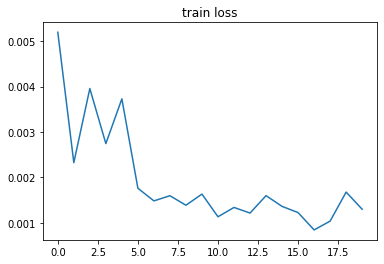

In [55]:
train(net,train_iter,loss_function,optimizer,num_epochs=20)

# make predict

In [56]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [57]:
y_pred = net(X_test).cpu().detach().numpy()
y_real = Y_test.cpu().detach().numpy()
y_pred = pd.DataFrame(y_pred,columns=y_col).apply(lambda x:round(x,3))
y_real = pd.DataFrame(y_real,columns=y_col)

In [58]:
y_pred.head()

,Individual Component to Light End Split Factor_Oxygen,Individual Component to Heart Cut Split Factor_Oxygen,Individual Component to Heavy End Split Factor_Oxygen,Individual Component to Light End Split Factor_Methane,Individual Component to Heart Cut Split Factor_Methane,Individual Component to Heavy End Split Factor_Methane,Individual Component to Light End Split Factor_Ethane,Individual Component to Heart Cut Split Factor_Ethane,Individual Component to Heavy End Split Factor_Ethane,Individual Component to Light End Split Factor_Propane,Individual Component to Heart Cut Split Factor_Propane,Individual Component to Heavy End Split Factor_Propane,Individual Component to Light End Split Factor_n-Butane,Individual Component to Heart Cut Split Factor_n-Butane,Individual Component to Heavy End Split Factor_n-Butane,Individual Component to Light End Split Factor_i-Pentane,Individual Component to Heart Cut Split Factor_i-Pentane,Individual Component to Heavy End Split Factor_i-Pentane,Individual Component to Light End Split Factor_n-Pentane,Individual Component to Heart Cut Split Factor_n-Pentane,Individual Component to Heavy End Split Factor_n-Pentane,Individual Component to Light End Split Factor_tr2-Pentene,Individual Component to Heart Cut Split Factor_tr2-Pentene,Individual Component to Heavy End Split Factor_tr2-Pentene,Individual Component to Light End Split Factor_Cyclopentane,Individual Component to Heart Cut Split Factor_Cyclopentane,Individual Component to Heavy End Split Factor_Cyclopentane,Individual Component to Light End Split Factor_3-Methylpentane,Individual Component to Heart Cut Split Factor_3-Methylpentane,Individual Component to Heavy End Split Factor_3-Methylpentane,Individual Component to Light End Split Factor_tr2-Hexene,Individual Component to Heart Cut Split Factor_tr2-Hexene,Individual Component to Heavy End Split Factor_tr2-Hexene,Individual Component to Light End Split Factor_n-Hexane,Individual Component to Heart Cut Split Factor_n-Hexane,Individual Component to Heavy End Split Factor_n-Hexane,Individual Component to Light End Split Factor_Methylcyclopentane,Individual Component to Heart Cut Split Factor_Methylcyclopentane,Individual Component to Heavy End Split Factor_Methylcyclopentane,"Individual Component to Light End Split Factor_2,2-Dimethylpentane","Individual Component to Heart Cut Split Factor_2,2-Dimethylpentane","Individual Component to Heavy End Split Factor_2,2-Dimethylpentane",Individual Component to Light End Split Factor_Benzene,Individual Component to Heart Cut Split Factor_Benzene,Individual Component to Heavy End Split Factor_Benzene,Individual Component to Light End Split Factor_Cyclohexane,Individual Component to Heart Cut Split Factor_Cyclohexane,Individual Component to Heavy End Split Factor_Cyclohexane,"Individual Component to Light End Split Factor_2,2,3-Trimethylbutane","Individual Component to Heart Cut Split Factor_2,2,3-Trimethylbutane","Individual Component to Heavy End Split Factor_2,2,3-Trimethylbutane",Individual Component to Light End Split Factor_4-Methyl-1-hexene,Individual Component to Heart Cut Split Factor_4-Methyl-1-hexene,Individual Component to Heavy End Split Factor_4-Methyl-1-hexene,Individual Component to Light End Split Factor_2-Methylhexane,Individual Component to Heart Cut Split Factor_2-Methylhexane,Individual Component to Heavy End Split Factor_2-Methylhexane,"Individual Component to Light End Split Factor_t-1,3-Dimethylcyclopentane","Individual Component to Heart Cut Split Factor_t-1,3-Dimethylcyclopentane","Individual Component to Heavy End Split Factor_t-1,3-Dimethylcyclopentane",Individual Component to Light End Split Factor_n-Heptane,Individual Component to Heart Cut Split Factor_n-Heptane,Individual Component to Heavy End Split Factor_n-Heptane,Individual Component to Light End Split Factor_H2O,Individual Component to Heart Cut Split Factor_H2O,Individual Component to Heavy End Split Factor_H2O,Individual Component to Light End Split Factor_Methylc

In [59]:
y_real.head()

,Individual Component to Light End Split Factor_Oxygen,Individual Component to Heart Cut Split Factor_Oxygen,Individual Component to Heavy End Split Factor_Oxygen,Individual Component to Light End Split Factor_Methane,Individual Component to Heart Cut Split Factor_Methane,Individual Component to Heavy End Split Factor_Methane,Individual Component to Light End Split Factor_Ethane,Individual Component to Heart Cut Split Factor_Ethane,Individual Component to Heavy End Split Factor_Ethane,Individual Component to Light End Split Factor_Propane,Individual Component to Heart Cut Split Factor_Propane,Individual Component to Heavy End Split Factor_Propane,Individual Component to Light End Split Factor_n-Butane,Individual Component to Heart Cut Split Factor_n-Butane,Individual Component to Heavy End Split Factor_n-Butane,Individual Component to Light End Split Factor_i-Pentane,Individual Component to Heart Cut Split Factor_i-Pentane,Individual Component to Heavy End Split Factor_i-Pentane,Individual Component to Light End Split Factor_n-Pentane,Individual Component to Heart Cut Split Factor_n-Pentane,Individual Component to Heavy End Split Factor_n-Pentane,Individual Component to Light End Split Factor_tr2-Pentene,Individual Component to Heart Cut Split Factor_tr2-Pentene,Individual Component to Heavy End Split Factor_tr2-Pentene,Individual Component to Light End Split Factor_Cyclopentane,Individual Component to Heart Cut Split Factor_Cyclopentane,Individual Component to Heavy End Split Factor_Cyclopentane,Individual Component to Light End Split Factor_3-Methylpentane,Individual Component to Heart Cut Split Factor_3-Methylpentane,Individual Component to Heavy End Split Factor_3-Methylpentane,Individual Component to Light End Split Factor_tr2-Hexene,Individual Component to Heart Cut Split Factor_tr2-Hexene,Individual Component to Heavy End Split Factor_tr2-Hexene,Individual Component to Light End Split Factor_n-Hexane,Individual Component to Heart Cut Split Factor_n-Hexane,Individual Component to Heavy End Split Factor_n-Hexane,Individual Component to Light End Split Factor_Methylcyclopentane,Individual Component to Heart Cut Split Factor_Methylcyclopentane,Individual Component to Heavy End Split Factor_Methylcyclopentane,"Individual Component to Light End Split Factor_2,2-Dimethylpentane","Individual Component to Heart Cut Split Factor_2,2-Dimethylpentane","Individual Component to Heavy End Split Factor_2,2-Dimethylpentane",Individual Component to Light End Split Factor_Benzene,Individual Component to Heart Cut Split Factor_Benzene,Individual Component to Heavy End Split Factor_Benzene,Individual Component to Light End Split Factor_Cyclohexane,Individual Component to Heart Cut Split Factor_Cyclohexane,Individual Component to Heavy End Split Factor_Cyclohexane,"Individual Component to Light End Split Factor_2,2,3-Trimethylbutane","Individual Component to Heart Cut Split Factor_2,2,3-Trimethylbutane","Individual Component to Heavy End Split Factor_2,2,3-Trimethylbutane",Individual Component to Light End Split Factor_4-Methyl-1-hexene,Individual Component to Heart Cut Split Factor_4-Methyl-1-hexene,Individual Component to Heavy End Split Factor_4-Methyl-1-hexene,Individual Component to Light End Split Factor_2-Methylhexane,Individual Component to Heart Cut Split Factor_2-Methylhexane,Individual Component to Heavy End Split Factor_2-Methylhexane,"Individual Component to Light End Split Factor_t-1,3-Dimethylcyclopentane","Individual Component to Heart Cut Split Factor_t-1,3-Dimethylcyclopentane","Individual Component to Heavy End Split Factor_t-1,3-Dimethylcyclopentane",Individual Component to Light End Split Factor_n-Heptane,Individual Component to Heart Cut Split Factor_n-Heptane,Individual Component to Heavy End Split Factor_n-Heptane,Individual Component to Light End Split Factor_H2O,Individual Component to Heart Cut Split Factor_H2O,Individual Component to Heavy End Split Factor_H2O,Individual Component to Light End Split Factor_Methylc

# metric

In [60]:
res = pd.DataFrame(index=y_col,columns=['MSE','MAPE'])
for i in y_col:
  res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
  res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,MSE,MAPE
Individual Component to Light End Split Factor_Oxygen,3.39201e-06,0.106699
Individual Component to Heart Cut Split Factor_Oxygen,1.71418e-06,NaN
Individual Component to Heavy End Split Factor_Oxygen,3.40699e-07,NaN
Individual Component to Light End Split Factor_Methane,1.53883e-06,0.0650743
Individual Component to Heart Cut Split Factor_Methane,1.4469e-07,NaN
Individual Component to Heavy End Split Factor_Methane,7.46258e-07,NaN
Individual Component to Light End Split Factor_Ethane,1.52387e-06,0.0604414
Individual Component to Heart Cut Split Factor_Ethane,4.60442e-07,NaN
Individual Component to Heavy End Split Factor_Ethane,3.21454e-07,NaN
Individual Component to Light End Split Factor_Propane,0.0191143,inf
